In [1]:
import numpy as np
import os
import matplotlib.image as mpimg

from util.helpers import *
from util.visualize import *
from util.cross_validation import cross_validate

### Load Training Images and Groundtruth versions

In [2]:
# Load the training set

image_dir = "training/images/"

print("Loading training input... ", end = '')
X = [np.asarray(load_image((image_dir + file))) for file in os.listdir(image_dir)]
print("done (" + str(len(X)) + " images).")
X = np.array(X)

gt_dir = "training/groundtruth/"
print("Loading training groundtruth... ", end = '')
Y = [np.asarray(load_image((gt_dir + file))) for file in os.listdir(gt_dir)]
print("done (" + str(len(Y)) + " images).")

Y = (np.array(Y) >= 0.25) * 1
# compensates for lossy image data

print()
print(X.shape)
print(Y.shape)

Loading training input... done (100 images).
Loading training groundtruth... done (100 images).

(100, 400, 400, 3)
(100, 400, 400)


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80, 400, 400, 3)
(20, 400, 400, 3)
(80, 400, 400)
(20, 400, 400)


In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
  print('set memory growth')
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass 

set memory growth


In [5]:
from resnet_50 import ResnetModel
model = ResnetModel()

initialize resnet 50 model


In [6]:
model.initialize()

create resnet 50 model
0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_

In [7]:
model.train(y_train, X_train)

Training set shape:  (80, 400, 400, 3)
28
(80, 456, 456, 3)
(80, 456, 456)
  ...
    to  
  ['...']
Train for 20 steps
20/20 [==============================] - 24s 1s/step - loss: 0.8057 - accuracy: 0.5660


In [19]:
def create_windows(X):
    window_size = 72
    focus_size = 16
    padding = (window_size - focus_size) // 2

    windows = np.asarray([img_crop(X[i], focus_size, focus_size, focus_size, padding) for i in range(X.shape[0])])
    return windows.reshape((-1, windows.shape[2], windows.shape[3], windows.shape[4]))

def recompose(Y, num_of_img, img_size):
    focus_size = 16

    Y = Y.reshape((num_of_img, math.ceil(img_size[0] / focus_size), math.ceil(img_size[1] / focus_size)))
    Y = np.transpose(Y, axes=[0, 2, 1])

    Y = np.repeat(Y, focus_size, axis=1)
    Y = np.repeat(Y, focus_size, axis=2)
    return Y[:, 0:img_size[0], 0:img_size[1]]

In [10]:
num_of_img = X_test.shape[0]
img_size = (X_test.shape[1], X_test.shape[2])
print(num_of_img)
print(img_size)
X_windows = create_windows(X_test)
print(X_windows.shape)

20
(400, 400)
(12500, 72, 72, 3)


In [11]:
Z = model.classify(X_windows)

In [20]:
Z.shape

(12500, 1)

In [21]:
Z1 = recompose(Z, num_of_img, img_size)

In [23]:
Z1.shape

(20, 400, 400)

In [24]:
y_test.shape

(20, 400, 400)

In [33]:
print(accuracy(Z1, y_test))
print(mean_f_score(Z1,y_test))

0.829245


ValueError: Samplewise metrics are not available outside of multilabel classification.

### Zero Classifier

In [32]:
from sklearn.metrics import f1_score
# score functions
def accuracy(Y, Y_star):
    Y = Y.reshape(-1)           # vectorize
    Y_star = Y_star.reshape(-1) # vectorize
    return np.sum(Y == Y_star) / Y.size

def mean_f_score(Y, Y_star):
    Y = Y.reshape(-1)           # vectorize
    Y_star = Y_star.reshape(-1) # vectorize

    return f1_score(Y_star, Y, average='samples')

In [3]:
from zero_classifier import ZeroClassifier
model = ZeroClassifier()

cross_validate(model, 4, X, Y) # 4 folds

Fold #1: 0.76504
Fold #2: 0.80802825
Fold #3: 0.79014775
Fold #4: 0.81782275

Cross Validation done:
[0.76504    0.80802825 0.79014775 0.81782275]
AVG: 0.7952596875
STD: 0.02007168026908107


### Logistic Regression

In [ ]:
from logistic_model import LogisticModel
model = LogisticModel()

cross_validate(model, 4, X, Y)

### Naive CNN Model

In [ ]:
from naive_cnn_model import NaiveCnnModel
model = NaiveCnnModel()

cross_validate(model, 4, X, Y)

In [ ]:
import util.visualize
import importlib
importlib.reload(util.visualize)

from util.visualize import *

from naive_cnn_model import NaiveCnnModel
cnn_model = NaiveCnnModel()

cnn_model.initialize()
cnn_model.train(Y, X)

In [ ]:
Y_pred = cnn_model.classify(X[0:10])

import util.visualize
import importlib
importlib.reload(util.visualize)

view_image_mask(X[4], Y_pred[4])

### SVM Model

In [ ]:
from svm_model import SvmModel
model = SvmModel()

cross_validate(model, 4, X, Y)

### Visualizing Results

In [4]:
from naive_cnn_model import NaiveCnnModel
cnn_model = NaiveCnnModel()

cnn_model.initialize()
cnn_model.train(Y, X)

Using TensorFlow backend.


Epoch 1/10
62500/62500 [==============================] - 23s 366us/step - loss: 0.5408 - accuracy: 0.7375
Epoch 2/10
62500/62500 [==============================] - 20s 326us/step - loss: 0.5000 - accuracy: 0.7509
Epoch 3/10
62500/62500 [==============================] - 21s 329us/step - loss: 0.4867 - accuracy: 0.7588
Epoch 4/10
62500/62500 [==============================] - 20s 324us/step - loss: 0.4702 - accuracy: 0.7675
Epoch 5/10
62500/62500 [==============================] - 24s 389us/step - loss: 0.4571 - accuracy: 0.7757
Epoch 6/10
62500/62500 [==============================] - 22s 348us/step - loss: 0.4480 - accuracy: 0.7831
Epoch 7/10
62500/62500 [==============================] - 21s 343us/step - loss: 0.4440 - accuracy: 0.7870
Epoch 8/10
62500/62500 [==============================] - 20s 318us/step - loss: 0.4393 - accuracy: 0.7885
Epoch 9/10
62500/62500 [==============================] - 19s 308us/step - loss: 0.4369 - accuracy: 0.7881
Epoch 10/10
62500/62500 [============

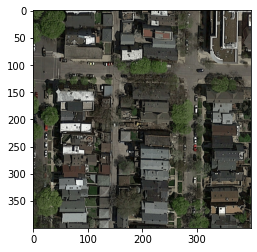

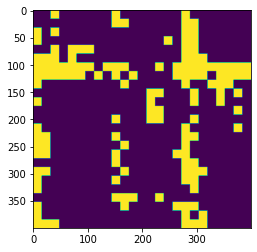

In [5]:
Y_pred = cnn_model.classify(X[0:10])

view_image_mask(X[4], Y_pred[4])